RMSE: 5.606107711791992


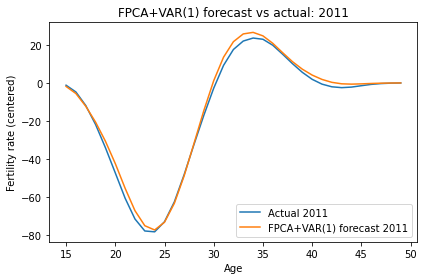

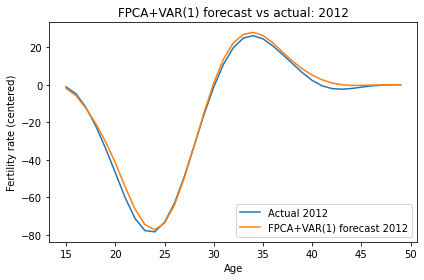

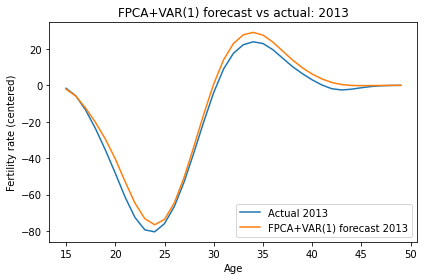

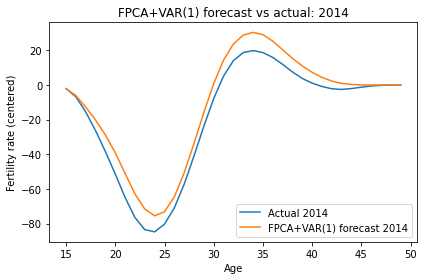

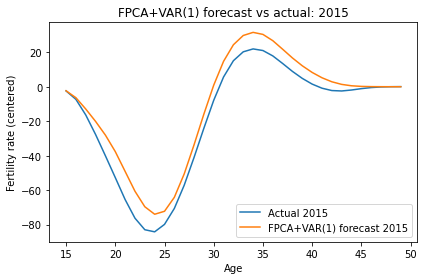

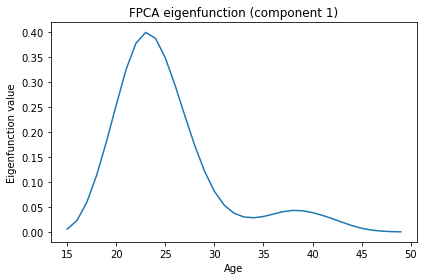

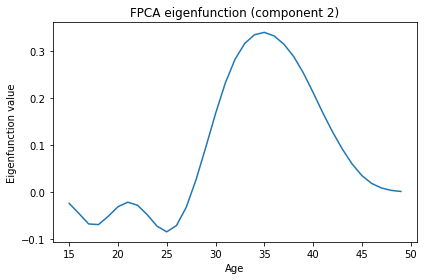

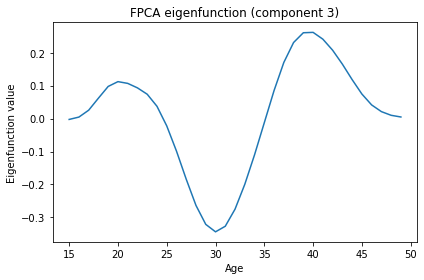

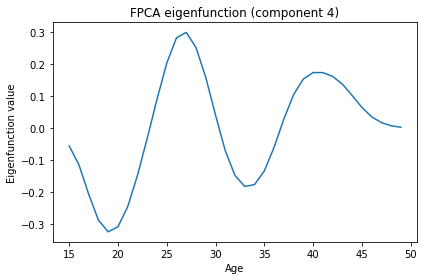

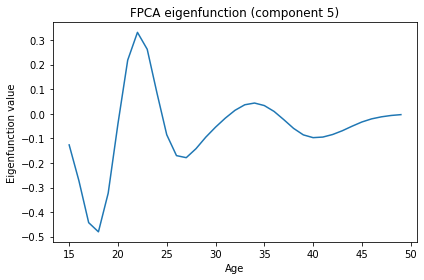

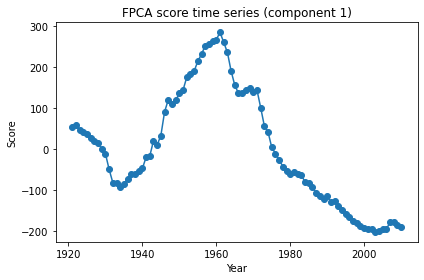

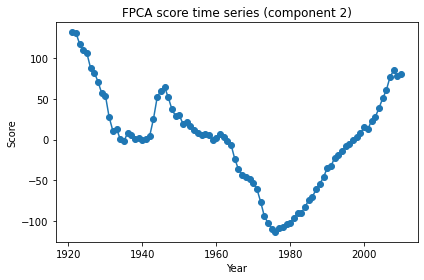

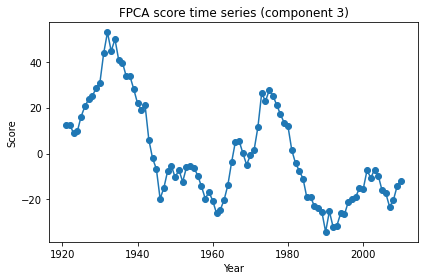

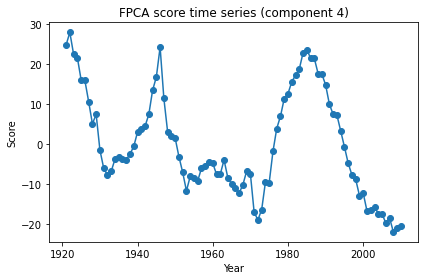

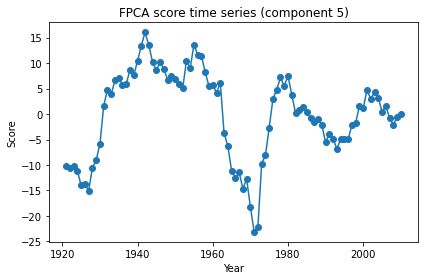

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"

import math
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

torch.set_num_threads(1)

def trapezoid_weights(x):
    x = np.asarray(x, float)
    order = np.argsort(x)
    x = x[order]
    dx = np.diff(x)
    w = np.zeros_like(x)
    w[0] = dx[0] / 2
    w[-1] = dx[-1] / 2
    if len(x) > 2:
        w[1:-1] = (x[2:] - x[:-2]) / 2
    return torch.tensor(w, dtype=torch.float32), order

def weighted_fpca_fit_numpy(X_train, w_age, K):
    X = X_train.detach().cpu().numpy()
    w = w_age.detach().cpu().numpy()
    mu = X.mean(axis=0, keepdims=True)
    Xc = X - mu
    sw = np.sqrt(w)[None, :]
    Xw = Xc * sw
    U, S, Vt = np.linalg.svd(Xw, full_matrices=False)
    V = Vt.T
    phi = (V[:, :K] / sw.reshape(-1, 1)).T
    for k in range(K):
        norm = np.sqrt(np.sum(phi[k] * phi[k] * w))
        phi[k] /= max(norm, 1e-12)
    scores = (Xc * w[None, :]) @ phi.T
    return (
        torch.tensor(mu.squeeze(0), dtype=torch.float32),
        torch.tensor(phi, dtype=torch.float32),
        torch.tensor(scores, dtype=torch.float32),
    )

def fit_var1(H, ridge=1e-8):
    T, K = H.shape
    X = H[:-1]
    Y = H[1:]
    X_aug = np.hstack([np.ones((T - 1, 1)), X])
    XtX = X_aug.T @ X_aug
    B = np.linalg.solve(XtX + ridge * np.eye(XtX.shape[0]), X_aug.T @ Y)
    b = B[0]
    A = B[1:].T
    return b, A

def forecast_var1(h_last, b, A, steps):
    out = []
    h = h_last.copy()
    for _ in range(steps):
        h = b + A @ h
        out.append(h.copy())
    return np.vstack(out)

def plot_year_by_year(ages, test_years, X_true, X_pred, title_prefix="FPCA"):
    for i, yr in enumerate(test_years):
        plt.figure()
        plt.plot(ages, X_true[i], label=f"Actual {yr}")
        plt.plot(ages, X_pred[i], label=f"{title_prefix} forecast {yr}")
        plt.xlabel("Age")
        plt.ylabel("Fertility rate (centered)")
        plt.title(f"{title_prefix} forecast vs actual: {yr}")
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_components(ages, phi, n_plot=5):
    kmax = min(n_plot, phi.shape[0])
    for k in range(kmax):
        plt.figure()
        plt.plot(ages, phi[k].detach().cpu().numpy())
        plt.xlabel("Age")
        plt.ylabel("Eigenfunction value")
        plt.title(f"FPCA eigenfunction (component {k+1})")
        plt.tight_layout()
        plt.show()

def plot_scores_over_time(train_years, scores, n_plot=5):
    H = scores.detach().cpu().numpy()
    kmax = min(n_plot, H.shape[1])
    for k in range(kmax):
        plt.figure()
        plt.plot(train_years, H[:, k], marker="o")
        plt.xlabel("Year")
        plt.ylabel("Score")
        plt.title(f"FPCA score time series (component {k+1})")
        plt.tight_layout()
        plt.show()

# ---- load data ----
df = pd.read_csv("Australiafertility.csv")
ages = df["age"].to_numpy()
year_cols = [c for c in df.columns if c != "age"]
years = np.array([int(c) for c in year_cols])
rates = df[year_cols].to_numpy()

# ---- simple moving average smoothing (no SciPy spline) ----
order = np.argsort(ages)
ages = ages[order]
rates = rates[order]
smoothed = np.zeros_like(rates, dtype=float)
for i in range(rates.shape[1]):
    y = rates[:, i].astype(float)
    ypad = np.pad(y, (1, 1), mode="edge")
    smoothed[:, i] = (ypad[:-2] + ypad[1:-1] + ypad[2:]) / 3.0

x = torch.tensor(smoothed.T, dtype=torch.float32)
x_mean = x.mean(0)
x_centered = x - x_mean

train_mask = years <= 2010
test_years = np.array([2011, 2012, 2013, 2014, 2015])
test_mask = np.isin(years, test_years)

x_train = x_centered[train_mask]
x_test = x_centered[test_mask]

# order chronologically
train_years = years[train_mask]
test_years_present = years[test_mask]
train_sort = np.argsort(train_years)
test_sort = np.argsort(test_years_present)

train_years = train_years[train_sort]
test_years_present = test_years_present[test_sort]
x_train = x_train[train_sort]
x_test = x_test[test_sort]

w_age, _ = trapezoid_weights(ages)
mu, phi, scores = weighted_fpca_fit_numpy(x_train, w_age, K=5)

# VAR forecast
H = scores.numpy()
b, A = fit_var1(H)
Hf = forecast_var1(H[-1], b, A, steps=len(test_years))
X_fore = mu[None, :] + torch.tensor(Hf, dtype=torch.float32) @ phi

rmse_val = torch.sqrt(((X_fore - x_test) ** 2).mean()).item()
print("RMSE:", rmse_val)

# ---- plots ----
X_true = x_test.detach().cpu().numpy()
X_pred = X_fore.detach().cpu().numpy()

plot_year_by_year(ages, test_years, X_true, X_pred, title_prefix="FPCA+VAR(1)")
plot_components(ages, phi, n_plot=5)
plot_scores_over_time(train_years, scores, n_plot=5)
